## Homework 2. Simple text processing.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Prohibited Comment Classification
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [ ]:
# In colab uncomment this cell
 ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic/homeworks/homework2_texts/comments.tsv

--2019-11-06 13:16:04--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic/homeworks/homework2_texts/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.02s   

2019-11-06 13:16:05 (20.0 MB/s) - ‘comments.tsv’ saved [353358/353358]



In [ ]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [ ]:
# task: preprocess each comment in train and test

texts_train = np.vectorize(preprocess)(texts_train)
texts_test = np.vectorize(preprocess)(texts_test)

In [ ]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [ ]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)

import operator


k = min(10000, len(set(' '.join(texts_train).split())))
from heapq import nlargest

uniq = []
for i in range(texts_train.size):
  for word in texts_train[i].split():
    if word not in uniq:
      uniq.append(word)
bow_vocabulary = []

for u in uniq:
  cntr = 0
  for i in range(texts_train.size):
    for word in texts_train[i].split():
     if word == u:
       cntr = cntr + 1
  bow_vocabulary.append((u, cntr))


bow_vocabulary.sort(key = operator.itemgetter(1))
bow_vocabulary.reverse()
bow_vocabulary = bow_vocabulary[:k]
bow_vocabulary = dict(bow_vocabulary)



print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [ ]:
bow_vocabulary = list(bow_vocabulary.keys())

In [ ]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    words = text.split()
    bag = np.zeros(len(bow_vocabulary))
    for word in words:
      for i in range(len(bow_vocabulary)):
        if word == bow_vocabulary[i]:
          bag[i] = bag[i] + 1
        i = i + 1

    return np.array(bag, 'float32')


In [ ]:
text_to_bow(texts_train[88])

array([2., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [ ]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [ ]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


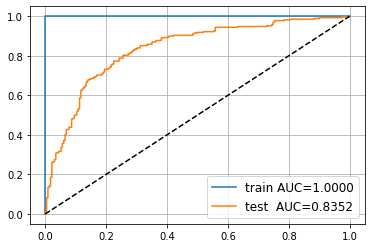

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [ ]:
def text_to_bow(text, vocabulary):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    words = text.split()
    bag = np.zeros(len(vocabulary))
    for word in words:
      for i in range(len(vocabulary)):
        if word == vocabulary[i]:
          bag[i] = bag[i] + 1
        i = i + 1

    return np.array(bag, 'float32')


In [ ]:
scores = []
for k in [10000, 8000, 6000, 5000, 4000, 3000, 2500, 2000, 1500, 1000, 500, 300, 100, 50, 10, 1]:
  voc = bow_vocabulary[:k]

  X_train_bow = np.stack(list(map(lambda x: text_to_bow(x, voc), texts_train)))
  X_test_bow = np.stack(list(map(lambda x: text_to_bow(x, voc), texts_test)))

  bow_model = LogisticRegression().fit(X_train_bow, y_train)
  y_pred = bow_model.predict(X_test_bow)
  score = roc_auc_score(y_pred, y_test)
  scores.append(score)
  print('k = ' + str(k) + ' roc auc score = ' + str(score))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 10000 roc auc score = 0.7623207885304658


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 8000 roc auc score = 0.7623207885304658


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 6000 roc auc score = 0.7623207885304658


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 5000 roc auc score = 0.7697132616487455


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 4000 roc auc score = 0.7654599577491839


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 3000 roc auc score = 0.7657130056323604


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 2500 roc auc score = 0.762


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 2000 roc auc score = 0.7737135176651306


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 1500 roc auc score = 0.7715831079675475


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 1000 roc auc score = 0.7654599577491839


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 500 roc auc score = 0.7518520296324741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 300 roc auc score = 0.7321557144914319


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 100 roc auc score = 0.7288461538461537


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k = 50 roc auc score = 0.7204065877509006
k = 10 roc auc score = 0.6557294295810197
k = 1 roc auc score = 0.583853791336376


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


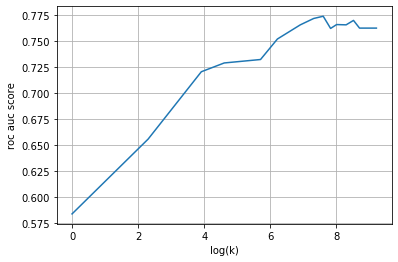

In [ ]:
import matplotlib.pyplot as plt
ks = [10000, 8000, 6000, 5000, 4000, 3000, 2500, 2000, 1500, 1000, 500, 300, 100, 50, 10, 1]
plt.plot(np.log(ks), scores)
plt.xlabel('log(k)')
plt.ylabel('roc auc score')
plt.grid(True)

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [ ]:
data = [
    [(word.replace(",", "")
          .replace(".", "")
          .replace("(", "")
          .replace(")", ""))
    for word in row.lower().split()]
    for row in texts]

texts_train, texts_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

In [ ]:
def computeReviewTFDict(review):
    
    reviewTFDict = {}
    for word in review:
        if word in reviewTFDict:
            reviewTFDict[word] += 1
        else:
            reviewTFDict[word] = 1
    
    for word in reviewTFDict:
        reviewTFDict[word] = reviewTFDict[word] / len(review)
    return reviewTFDict

In [ ]:
tfDict = list(map(computeReviewTFDict, texts_train))

In [ ]:
texts_train[0]

['',
 'oh',
 'and',
 'what',
 'kind',
 'of',
 'person',
 'watches',
 'another',
 'persons',
 'mytalk',
 'page?',
 'stalker!']

In [ ]:
tfDict[0]

{'': 0.07692307692307693,
 'and': 0.07692307692307693,
 'another': 0.07692307692307693,
 'kind': 0.07692307692307693,
 'mytalk': 0.07692307692307693,
 'of': 0.07692307692307693,
 'oh': 0.07692307692307693,
 'page?': 0.07692307692307693,
 'person': 0.07692307692307693,
 'persons': 0.07692307692307693,
 'stalker!': 0.07692307692307693,
 'watches': 0.07692307692307693,
 'what': 0.07692307692307693}

In [ ]:
 def computeCountDict():
   
    countDict = {}
    
    for review in tfDict:
        for word in review:
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
    return countDict

  
countDict = computeCountDict()

In [ ]:
countDict["person"]

13

In [ ]:
import math
def computeIDFDict(data, a):

    idfDict = {}
    for word in countDict:
        idfDict[word] = math.log(len(data) / (countDict[word]+a))
    return idfDict
  
  
idfDict = computeIDFDict(texts_train, a = 1)

In [ ]:
idfDict['person']

3.575550768806933

In [ ]:
def computeReviewTFIDFDict(reviewTFDict, a):

    reviewTFIDFDict = {}
    
    for word in reviewTFDict:
      if word in idfDict:
        reviewTFIDFDict[word] = reviewTFDict[word] * idfDict[word]
      else:
        # если нашего слова нет в idf словаре -- не значит, что его не надо 
        # учитывать. Добавим его значение со следущей оценкой: слово встретилось 
        # ни в одном документе, но деления на ноль не будет, т.к. мы ввели
        # параметр a в знаменателе.
        idfDict[word] = math.log(len(texts_train) / a)
    return reviewTFIDFDict

tfidfDict = [computeReviewTFIDFDict(review, a = 1) for review in tfDict]

In [ ]:
tfidfDict[0]

{'': 0.19428681879294274,
 'and': 0.059066978981221686,
 'another': 0.2476058326821693,
 'kind': 0.27504236683130256,
 'mytalk': 0.4247277629124805,
 'of': 0.06315235015921772,
 'oh': 0.2869001114333994,
 'page?': 0.35424386046062245,
 'person': 0.27504236683130256,
 'persons': 0.3283613807205292,
 'stalker!': 0.4247277629124805,
 'watches': 0.4247277629124805,
 'what': 0.1459323065296832}

In [ ]:
wordDict = sorted(countDict.keys())

def computeTFIDFVector(review):
    tfidfVector = [0.0] * len(wordDict)
     
      
    for i, word in enumerate(wordDict):
        if word in review:
          tfidfVector[i] = review[word]
    return tfidfVector

tfidfVector = [computeTFIDFVector(review) for review in tfidfDict]

In [ ]:
print(len(tfidfVector))
print(len(tfidfVector[1]))

500
6258


Now we will use IDF vector from the training set to calculate  TF-IDF vectors on the test set.

In [ ]:
tfDict_test = list(map(computeReviewTFDict, texts_test))

In [ ]:
tfidfDict_test = [computeReviewTFIDFDict(review, 1) for review in tfDict_test]

In [ ]:
tfidfDict_test[0]

{'a': 0.11753662696570241,
 'life': 0.5450281865426252,
 'need': 0.5450281865426252,
 'really': 0.5364793041447,
 'you': 0.11552453009332421}

In [ ]:
tfidfVector_test = [computeTFIDFVector(review) for review in tfidfDict_test]

In [ ]:
len(tfidfVector)

500

In [ ]:
tfidf_model = LogisticRegression().fit(tfidfVector, y_train)
y_pred = tfidf_model.predict(tfidfVector_test)
print(roc_auc_score(y_pred, y_test))

0.778861322242937


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


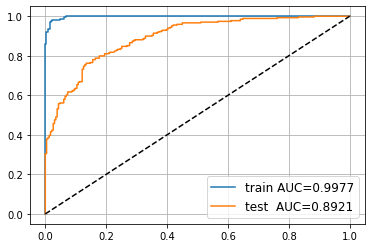

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', tfidfVector, y_train, tfidf_model),
    ('test ', tfidfVector_test, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

TF-IDF results are better than BOW. This is expected because tf-idf contains more information than  a bag of words.